<a href="https://colab.research.google.com/github/srikharshashi/learn-dl/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [3]:
IMAGE_SHAPE = (224, 224)

classifier = m = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/5",input_shape=(224,224,3))
])



In [4]:
gold_fish_img=Image.open('Goldfish.jpg').resize(IMAGE_SHAPE)
gold_fish=np.array(gold_fish_img)/255.0

In [5]:
gold_fish=np.array(gold_fish)

In [6]:
gold_fish.shape

(224, 224, 3)

In [7]:
result=classifier.predict(gold_fish[np.newaxis,...])

1/1 [==============================] - 10s 10s/step


In [8]:
result.shape

(1, 1001)

In [9]:
predicted_index=np.argmax(result)
predicted_index

2

In [10]:
image_labels = []
with open("ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()
image_labels[:5]
  

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [11]:
image_labels[predicted_index]

'goldfish'

In [12]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory


In [13]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir


PosixPath('datasets/flower_photos')

In [14]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}


In [15]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}


In [16]:
str(flowers_images_dict['roses'][0])


'datasets/flower_photos/roses/12243068283_ee4c2683e2_n.jpg'

In [17]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))


In [18]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])


In [19]:
X = np.array(X)
y = np.array(y)


In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


In [21]:
type(X_train)

numpy.ndarray

In [22]:
X_train_scaled = X_train / 255.0
X_test_scaled = X_test / 255.0

In [23]:
IMAGE_SHAPE+(3,)


(224, 224, 3)

In [24]:
x0_resized = cv2.resize(X[0], IMAGE_SHAPE)
x1_resized = cv2.resize(X[1], IMAGE_SHAPE)
x2_resized = cv2.resize(X[2], IMAGE_SHAPE)


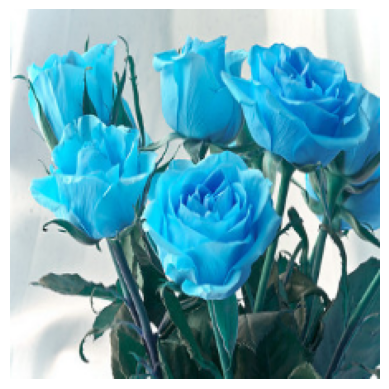

In [25]:
plt.axis('off')
plt.imshow(X[0])


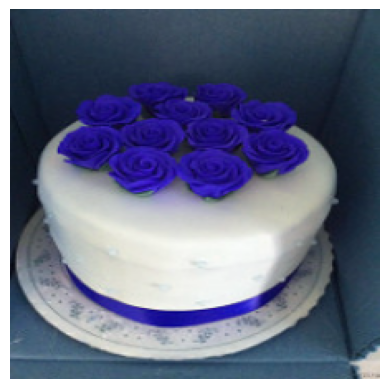

In [26]:
plt.axis('off')
plt.imshow(X[2])


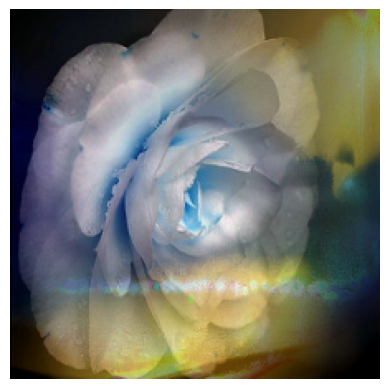

In [27]:
plt.axis('off')
plt.imshow(X[1])


In [28]:
predicted = classifier.predict(np.array([x0_resized, x1_resized, x2_resized]))
predicted = np.argmax(predicted, axis=1)
predicted


1/1 [==============================] - 1s 1s/step


array([283, 905, 667])

In [29]:
image_labels[283],image_labels[905],image_labels[667]

('tiger cat', 'window screen', 'mortar')

Using a pretrained model and retrain it to recognize flowers

In [30]:
feature_extractor_model = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/5"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)


In [31]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1792)              4363712   
                                                                 
 dense (Dense)               (None, 5)                 8965      
                                                                 
Total params: 4,372,677
Trainable params: 8,965
Non-trainable params: 4,363,712
_________________________________________________________________


In [32]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=5)


Epoch 1/5
86/86 [==============================] - 11s 55ms/step - loss: 0.6470 - acc: 0.7627
Epoch 2/5
86/86 [==============================] - 5s 55ms/step - loss: 0.3066 - acc: 0.8928
Epoch 3/5
86/86 [==============================] - 5s 57ms/step - loss: 0.2263 - acc: 0.9295
Epoch 4/5
86/86 [==============================] - 5s 55ms/step - loss: 0.1838 - acc: 0.9488
Epoch 5/5
86/86 [==============================] - 5s 56ms/step - loss: 0.1509 - acc: 0.9615


In [33]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 3s 85ms/step - loss: 0.2769 - acc: 0.9063


[0.27693626284599304, 0.9063180685043335]

We went from a test accuracy of 70% to test accuracy of 90% while using transfer learning